In [1]:
import pandas as pd
import pickle

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics
import sklearn.neighbors
from sklearn.neighbors import kneighbors_graph
from sklearn.model_selection import train_test_split

import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

In [2]:
pd.set_option('display.max_columns',None)

In [4]:
summary = pd.read_csv("summary.csv",index_col=0)
summary

,playerId,playId,meanDistance,meanDistanceAfterPass,numberPlayers5yds,numberPlayers5ydsAfterPass,areaDifference,numberPlayersDeep,numberPlayersDeepDifference,numberPlayersUnderneath,densityDifference,heightDifference,widthDifference,cluster,homeScore,visitorScore,down,quarter,yardsToGo,yardsToEndZone,gameClock,defenseValoration
0,71251.0,2018093006:2225:4,10.568907,11.791571,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,00:07:00,0
1,89756.0,2018093006:2225:4,10.946105,4.581272,0.264706,0.8,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,00:07:00,0
2,494287.0,2018093006:2225:4,31.074778,19.611594,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,00:07:00,0
3,2533062.0,2018093006:2225:4,22.644911,19.288428,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,00:07:00,0
4,2541243.0,2018093006:2225:4,24.893454,14.407899,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,00:07:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,2550164.0,2018120902:699:14,8.330134,4.746337,0.148148,0.7,-172.00910,5,4,2,-0.040696,-10.46,-55.60,0.0,7.0,7.0,3,1,21,63.0,03:29:00,1
753,2552389.0,2018120902:699:14,17.275020,3.427559,0.000000,0.7,-172.00910,5,4,2,-0.040696,-10.46,-55.60,0.0,7.0,7.0,3,1,21,63.0,03:29:00,1
754,2555166.0,2018120902:699:14,10.335948,4.058543,0.000000,0.7,-172.00910,5,4,2,-0.040696,-10.46,-55.60,0.0,7.0,7.0,3,1,21,63.0,03:29:00,1
755,2555540.0,2018120902:699:14,15.836416,8.746987,0.000000,0.0,-172.00910,5,4,2,-0.040696,-10.46,-55.60,0.0,7.0,7.0,3,1,21,63.0,03:29:00,1


In [56]:
len(summary[summary["defenseValoration"]==0])/len(summary)

0.44596912521440824

In [57]:
len(summary[summary["defenseValoration"]==1])/len(summary)

0.5540308747855918

# Cambiar valor gameClock

In [20]:
from datetime import datetime
s1 = "15:00:00"
s2 = "03:29:00"
format = "%M:%S:%f"
time = datetime.strptime(s1, format) - datetime.strptime(s2, format)
print(time.total_seconds())
print(str(time).split(":"))

691.0
['0', '11', '31']


In [45]:
def changeGameClock(value,quarter):
    if quarter == 1:
        total_time = 3600
    elif quarter == 2:
        total_time = 2700
    elif quarter == 3:
        total_time = 1800
    elif quarter == 4:
        total_time = 900
    
    format = "%M:%S:%f"
    actual_time = datetime.strptime(value, format) - datetime.strptime("00:00:00",format)
    time = total_time - (900 - actual_time.total_seconds())
    return time

In [46]:
changeGameClock("00:07:00",2)

1807.0

In [47]:
summary_cp = summary.copy()

In [48]:
summary_cp["gameClock"] = summary_cp.apply(lambda x: changeGameClock(x["gameClock"],x["quarter"]),axis=1)

In [49]:
summary_cp.drop(["playerId","playId"],axis=1,inplace=True)

In [50]:
summary_cp

,meanDistance,meanDistanceAfterPass,numberPlayers5yds,numberPlayers5ydsAfterPass,areaDifference,numberPlayersDeep,numberPlayersDeepDifference,numberPlayersUnderneath,densityDifference,heightDifference,widthDifference,cluster,homeScore,visitorScore,down,quarter,yardsToGo,yardsToEndZone,gameClock,defenseValoration
0,10.568907,11.791571,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,1807.0,0
1,10.946105,4.581272,0.264706,0.8,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,1807.0,0
2,31.074778,19.611594,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,1807.0,0
3,22.644911,19.288428,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,1807.0,0
4,24.893454,14.407899,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,1807.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,8.330134,4.746337,0.148148,0.7,-172.00910,5,4,2,-0.040696,-10.46,-55.60,0.0,7.0,7.0,3,1,21,63.0,2909.0,1
753,17.275020,3.427559,0.000000,0.7,-172.00910,5,4,2,-0.040696,-10.46,-55.60,0.0,7.0,7.0,3,1,21,63.0,2909.0,1
754,10.335948,4.058543,0.000000,0.7,-172.00910,5,4,2,-0.040696,-10.46,-55.60,0.0,7.0,7.0,3,1,21,63.0,2909.0,1
755,15.836416,8.746987,0.000000,0.0,-172.00910,5,4,2,-0.040696,-10.46,-55.60,0.0,7.0,7.0,3,1,21,63.0,2909.0,1


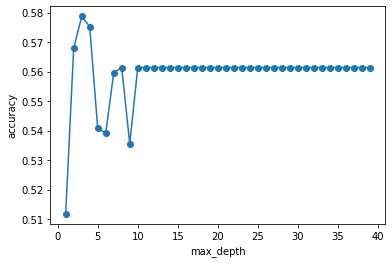

In [58]:
from sklearn import tree
from sklearn.model_selection import KFold

cv = KFold(n_splits = 10, shuffle = False) # 
accuracies = list()
max_attributes = len(list(summary_cp))
depth_range = range(1, max_attributes * 2)

# from 1 to number of features * 2

for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy', 
                                             min_samples_split = 65, 
                                             min_samples_leaf = 20,
                                             max_depth = depth,
                                             class_weight={0:5.5,1:4.4}
                                            )
    for train_fold, test_fold in cv.split(summary_cp):
        f_train = summary_cp.iloc[train_fold]
        f_test = summary_cp.iloc[test_fold]
        
        model = tree_model.fit( X = f_train.drop(['defenseValoration'], axis=1), 
                               y = f_train['defenseValoration'])
        test_acc = model.score(X = f_test.drop(['defenseValoration'], axis=1), 
                                y = f_test['defenseValoration'])
        fold_accuracy.append(test_acc)
        
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
import matplotlib.pyplot as plt    
plt.plot(depth_range, accuracies, marker='o')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.show()

In [78]:
X_train, X_test, y_train, y_test = train_test_split(summary_cp.drop(["defenseValoration"],axis=1),summary_cp["defenseValoration"],test_size=0.2)

In [84]:
X_train

,meanDistance,meanDistanceAfterPass,numberPlayers5yds,numberPlayers5ydsAfterPass,areaDifference,numberPlayersDeep,numberPlayersDeepDifference,numberPlayersUnderneath,densityDifference,heightDifference,widthDifference,cluster,homeScore,visitorScore,down,quarter,yardsToGo,yardsToEndZone,gameClock
421,9.722823,8.733376,0.000000,0.000000,256.90085,3,3,4,0.027248,6.77,-19.31,1.0,23.0,20.0,3,4,7,27.0,743.0
750,6.548196,2.938187,0.370370,1.000000,-172.00910,5,4,2,-0.040696,-10.46,-55.60,0.0,7.0,7.0,3,1,21,63.0,2909.0
549,4.845408,4.040300,0.757576,1.000000,54.71050,1,0,6,0.127946,5.28,-27.60,1.0,28.0,17.0,3,2,4,39.0,1837.0
581,7.310337,5.950939,0.000000,0.000000,104.41625,2,2,5,0.067039,2.32,-22.70,0.0,0.0,0.0,3,1,6,76.0,3532.0
720,3.554260,1.195975,1.275862,1.000000,160.91030,1,1,6,0.043502,7.49,-19.45,0.0,0.0,0.0,3,1,3,41.0,3422.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,1.465822,1.383324,1.000000,1.000000,237.30175,2,1,6,0.033712,5.37,-24.07,0.0,16.0,7.0,3,2,10,24.0,1812.0
608,5.302089,5.459386,0.433333,0.166667,-0.47755,1,0,5,-12.564129,1.99,-28.37,1.0,25.0,14.0,3,4,3,47.0,119.0
232,5.793807,2.268440,0.400000,1.000000,231.31470,2,2,5,0.030262,4.01,-23.07,0.0,14.0,3.0,3,2,11,61.0,2594.0
560,5.713841,5.094155,0.486486,0.645161,20.35925,3,2,4,0.343824,-7.20,-47.40,1.0,7.0,10.0,3,2,11,76.0,2587.0


In [79]:
from sklearn.metrics import accuracy_score
regressor = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split = 65, 
                                  min_samples_leaf = 20, max_depth = 10, 
                                  class_weight={0:5.5,1:4.4})
regressor.fit( X = X_train, y = y_train)
y_pred = regressor.predict(X = X_test)
acc = accuracy_score(y_test, y_pred)
print ('Acc', acc)

Acc 0.905982905982906


In [77]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,normalize=False,title=None,cmap=plt.cm.Blues):
  
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix
[[0.93333333 0.06666667]
 [0.18055556 0.81944444]]


TypeError: 'str' object is not callable

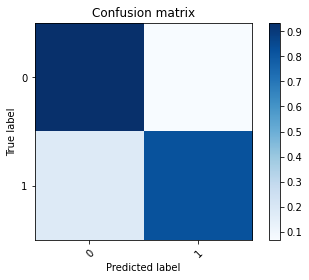

In [76]:
plot_confusion_matrix(y_test, y_pred, classes=unique_labels(y_test,y_pred), normalize=True,
                      title='Confusion matrix')

In [81]:
X_train, X_test, y_train, y_test = train_test_split(summary_cp.drop(["defenseValoration"],axis=1),summary_cp["defenseValoration"],test_size=0.2)

In [82]:
from sklearn.ensemble import RandomForestClassifier

#1.1 Model Parametrization 
regressor = RandomForestClassifier(n_estimators= 100, max_depth = 10, random_state=0)
#1.2 Model construction
regressor.fit(X_train, y_train)

# Test
y_pred = regressor.predict(X_test)

# metrics calculation 
from sklearn.metrics import mean_absolute_error
acc = accuracy_score(y_test, y_pred)
print ('Acc', acc)

Acc 1.0


Normalized confusion matrix
[[1. 0.]
 [0. 1.]]


TypeError: 'str' object is not callable

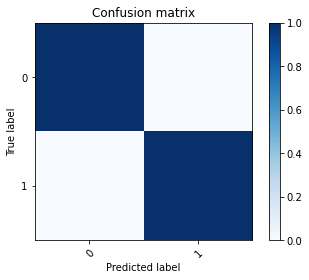

In [83]:
plot_confusion_matrix(y_test, y_pred, classes=unique_labels(y_test,y_pred), normalize=True,
                      title='Confusion matrix')

# Normalización de los datos

In [ ]:
scaler = preprocessing.StandardScaler()
summary_1 = scaler.fit_transform(static_defenses.drop(["playResult"],axis=1))

In [ ]:
scaler = preprocessing.MinMaxScaler()
summary_1 = scaler.fit_transform(static_defenses.drop(["playResult"],axis=1))

In [ ]:
scaler = preprocessing.RobustScaler()
summary_1 = scaler.fit_transform(static_defenses.drop(["playResult"],axis=1))

In [ ]:
scaler = preprocessing.PowerTransformer()
summary_1 = scaler.fit_transform(static_defenses.drop(["playResult"],axis=1))